In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import os

In [115]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [ ]:
transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_data = datasets.MNIST('/Users/kevingill/PhD/ML/MNIST_example/Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('/Users/kevingill/PhD/ML/MNIST_example/Data', train=False, transform=transform)

# obtain training indices that will be used for validation
valid_size = 0.2 # percentage of training set to use as validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index, valid_index = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size =64, sampler = valid_sampler)



In [108]:
# define NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        # number of hidden nodes in each layer
        hidden_1 = 300
        hidden_2 = 200
        # hidden_3 = 100
        output = 10
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28*28,hidden_1)
        # linear layer (hidden_1 -> hidden_2)
        self.fc2 = nn.Linear(hidden_1,hidden_2)
        # linear layer (hidden_2 -> 10)
        self.fc3 = nn.Linear(hidden_2,output)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)
        
    def forward(self,x):
        # flatten image input
        x = x.view(-1,28*28)
        # add hidden layer, with sigmoid activation function
        x = torch.sigmoid(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
         # add hidden layer, with sigmoid activation function
        x = torch.sigmoid(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer, with softmax operation
        x = torch.softmax(self.fc3(x), dim=1)
        
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [109]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()
# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = torch.optim.SGD(model.parameters(),lr = 0.1)

In [ ]:
# number of epochs to train the model
n_epochs = 50
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf  # set initial "min" to infinity
train_losses = []
valid_losses = []
for epoch in range(n_epochs):
    # monitor losses
    train_loss = 0
    valid_loss = 0
     
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data,label in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * data.size(0)
        
     ######################    
    # validate the model #
    ######################
    model.eval()  # prep model for evaluation
    for data,label in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # update running validation loss 
        valid_loss = loss.item() * data.size(0)
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

In [111]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval() # prep model for evaluation
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.508120

Test Accuracy of     0: 98% (969/980)
Test Accuracy of     1: 98% (1114/1135)
Test Accuracy of     2: 94% (978/1032)
Test Accuracy of     3: 94% (959/1010)
Test Accuracy of     4: 96% (944/982)
Test Accuracy of     5: 91% (815/892)
Test Accuracy of     6: 96% (928/958)
Test Accuracy of     7: 95% (984/1028)
Test Accuracy of     8: 95% (928/974)
Test Accuracy of     9: 93% (944/1009)

Test Accuracy (Overall): 95% (9563/10000)


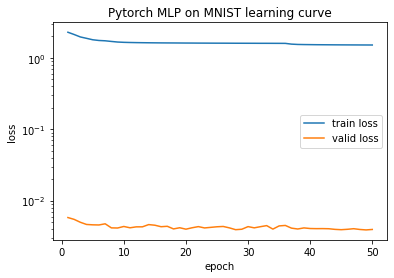

In [116]:
epochs = np.arange(1,n_epochs+1)
plt.semilogy(epochs, train_losses, label='train loss')
plt.semilogy(epochs, valid_losses, label='valid loss')
plt.legend()
plt.title('Pytorch MLP on MNIST learning curve')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('mlp_pytorch.pdf')
plt.show()